In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

**LOADING DATA FROM KAGGLE USING API**

In [ ]:
from google.colab import files
uploaded=files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 63 bytes


In [ ]:
!kaggle datasets download -d gti-upm/leapgestrecog

Dataset URL: https://www.kaggle.com/datasets/gti-upm/leapgestrecog
License(s): CC-BY-NC-SA-4.0
100% 2.13G/2.13G [01:39<00:00, 21.8MB/s]
100% 2.13G/2.13G [01:39<00:00, 23.0MB/s]


**UNZIP THE DATA**

In [ ]:
from zipfile import ZipFile
file_name = "/content/leapgestrecog.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [ ]:
data="/content/leapGestRecog"

**DATA AUGMENTATION**

In [ ]:
image_size = (128, 128)
batch_size = 64

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)


train_generator = train_datagen.flow_from_directory(
    data,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)


validation_generator = train_datagen.flow_from_directory(
    data,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)


Found 16000 images belonging to 10 classes.
Found 4000 images belonging to 10 classes.


In [ ]:
from builtins import zip as builtin_zip

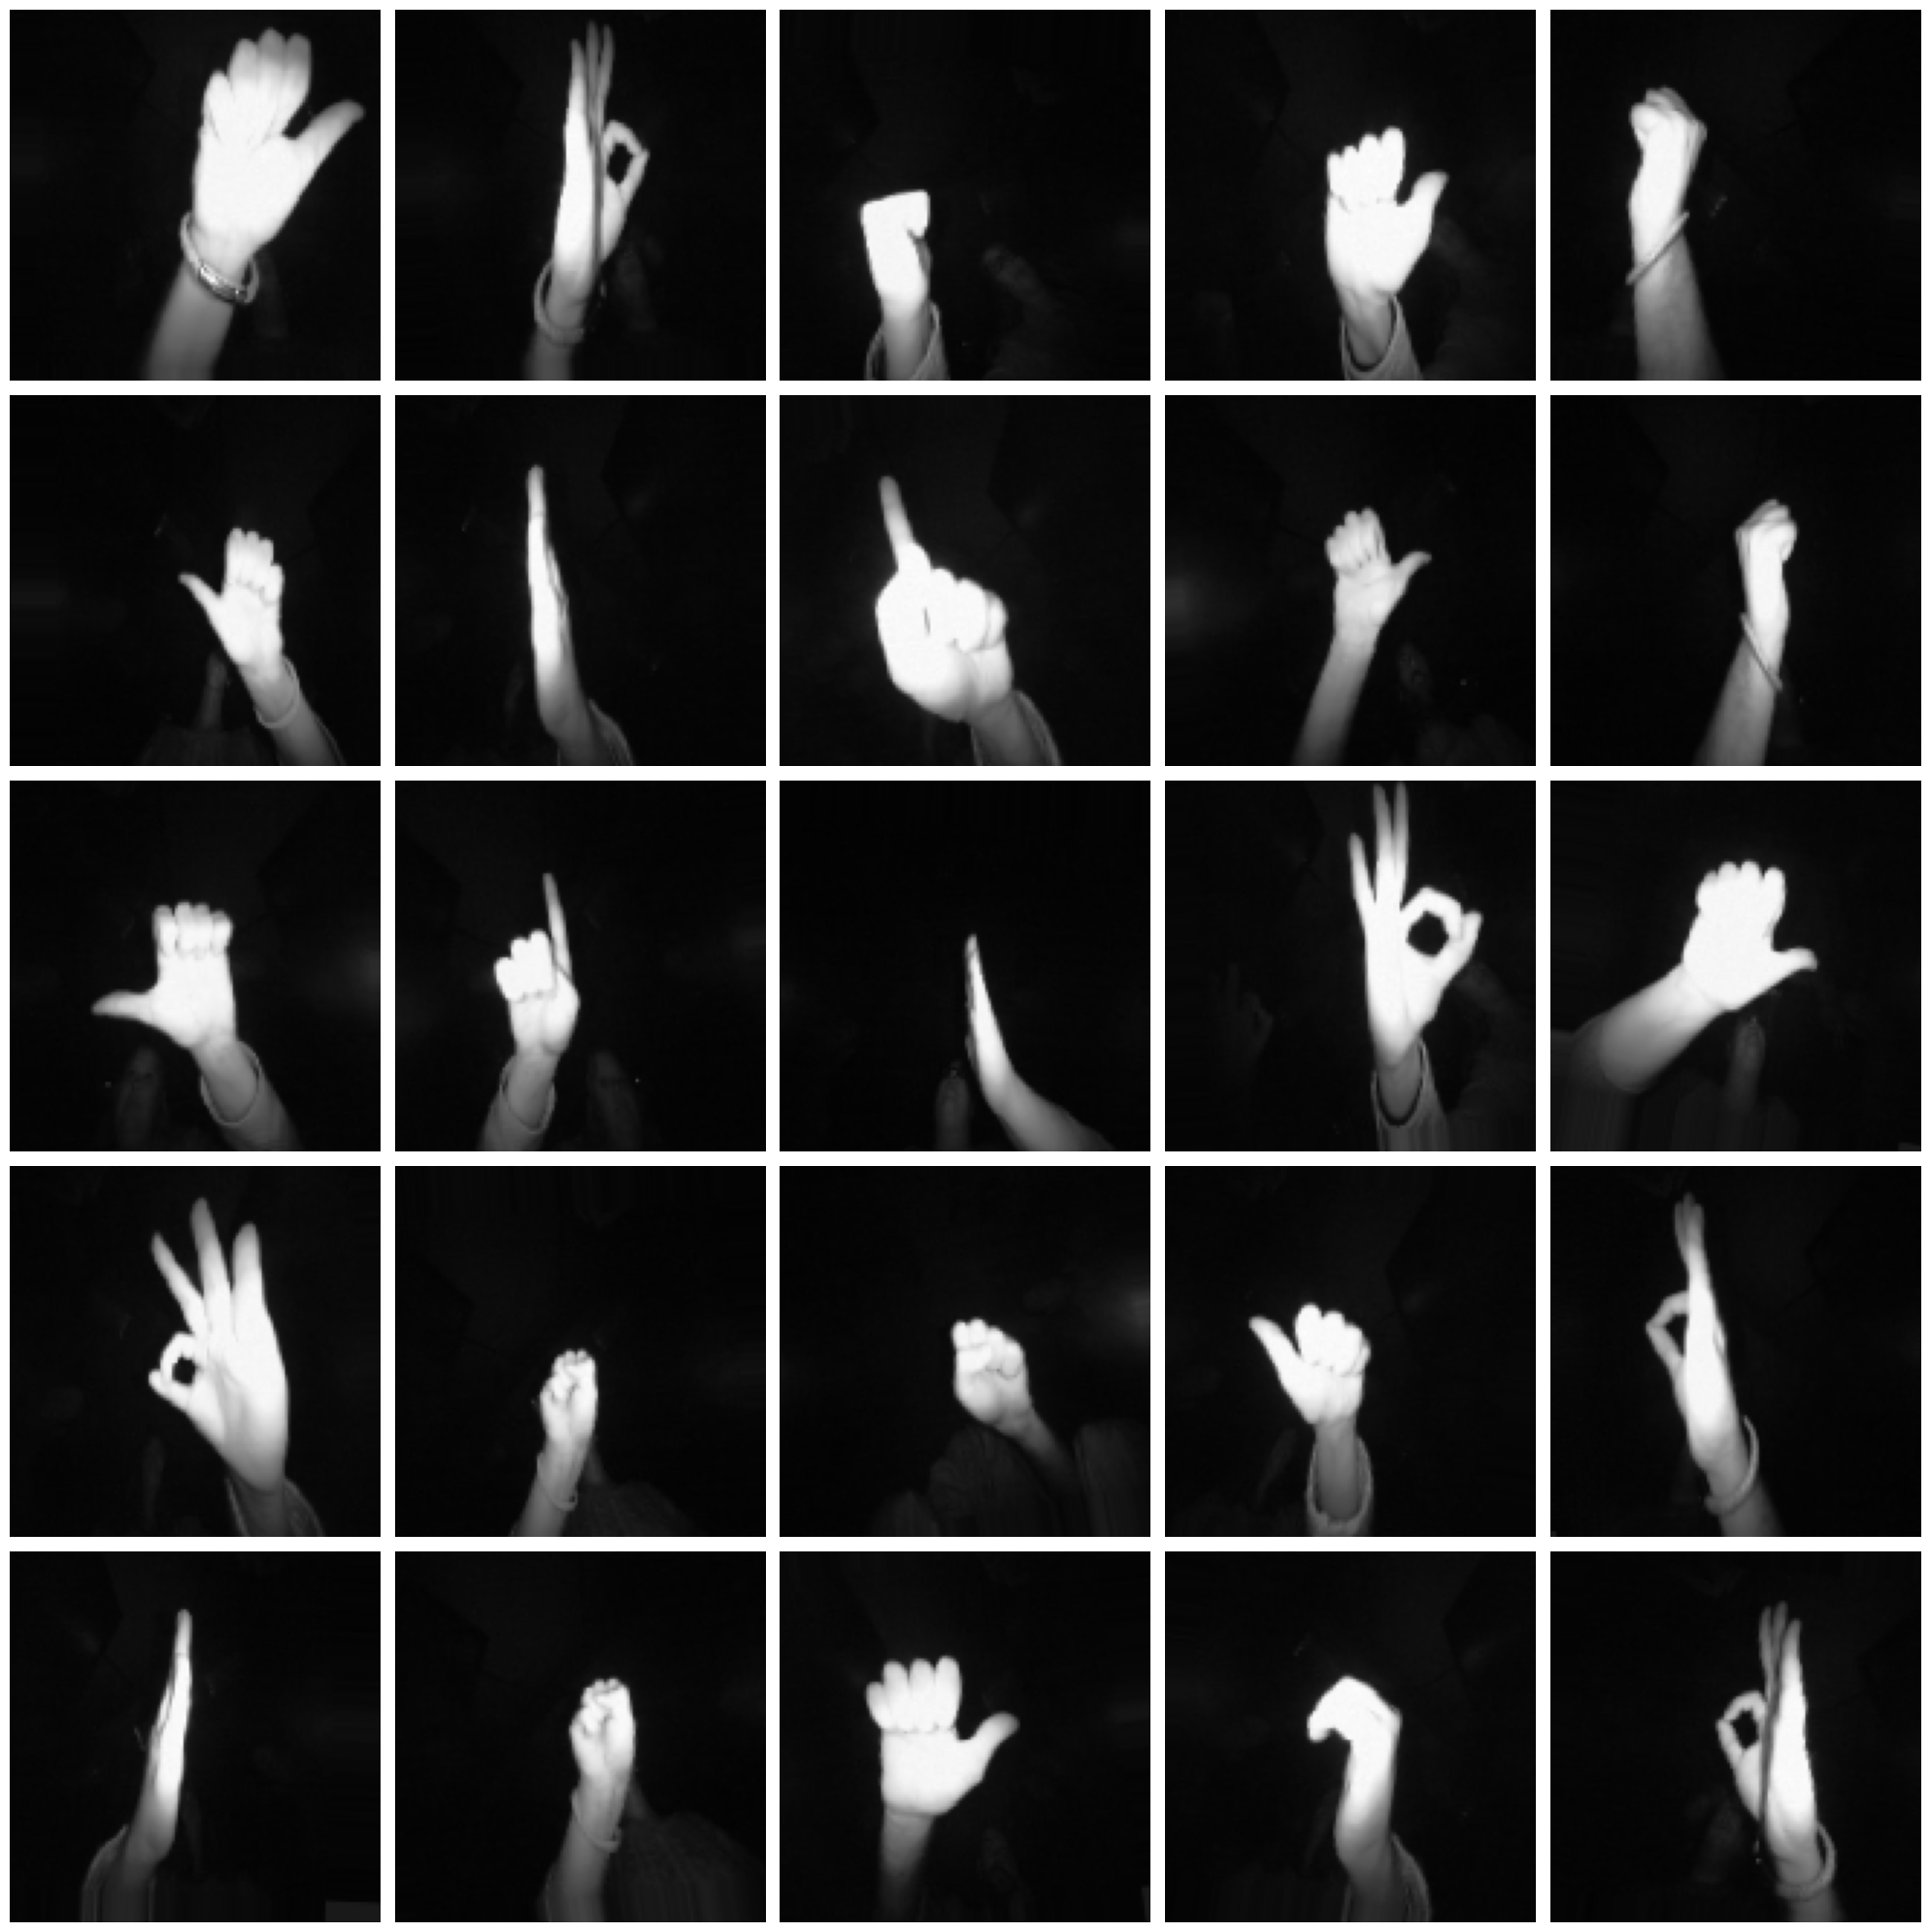

In [ ]:
x, y = next(train_generator)


fig, axes = plt.subplots(5, 5, figsize=(20, 20))
axes = axes.flatten()
for img, ax in builtin_zip(x, axes):
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

**TRAINING WITH CNN MODEL**

In [ ]:

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(1228, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(len(train_generator.class_indices), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 1228)      354892    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 1228)      0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 256)       2829568   
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 256)       0

In [ ]:

history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)


Epoch 1/10
250/250 [==============================] - 162s 648ms/step - loss: 0.0455 - accuracy: 0.9809 - val_loss: 0.2983 - val_accuracy: 0.9390
Epoch 2/10
250/250 [==============================] - 138s 550ms/step - loss: 0.0429 - accuracy: 0.9800 - val_loss: 0.2422 - val_accuracy: 0.9402
Epoch 3/10
250/250 [==============================] - 139s 555ms/step - loss: 0.0453 - accuracy: 0.9799 - val_loss: 0.2210 - val_accuracy: 0.9507
Epoch 4/10
250/250 [==============================] - 137s 546ms/step - loss: 0.0498 - accuracy: 0.9779 - val_loss: 0.2598 - val_accuracy: 0.9402
Epoch 5/10
250/250 [==============================] - 139s 555ms/step - loss: 0.0392 - accuracy: 0.9813 - val_loss: 0.2990 - val_accuracy: 0.9388
Epoch 6/10
250/250 [==============================] - 138s 551ms/step - loss: 0.0458 - accuracy: 0.9801 - val_loss: 0.2084 - val_accuracy: 0.9572
Epoch 7/10
250/250 [==============================] - 145s 582ms/step - loss: 0.0394 - accuracy: 0.9811 - val_loss: 0.2807 -

In [ ]:
loss, accuracy = model.evaluate(validation_generator)
print(f"Validation Accuracy: {accuracy*100:.2f}%")

63/63 [==============================] - 25s 396ms/step - loss: 0.2402 - accuracy: 0.9438
Validation Accuracy: 94.38%


In [ ]:
import tensorflow as tf


converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()


with open('hand_gesture_model.tflite', 'wb') as f:
    f.write(tflite_model)


**DEPLOYMENT**

**PREDICTING THE REAL TIME IMAGE**

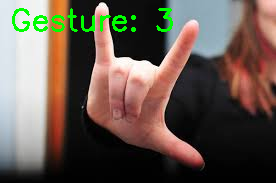

Predicted Gesture for /content/images (4).jpeg: 3


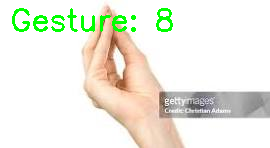

Predicted Gesture for /content/images (1).jpeg: 8


In [ ]:
import cv2
import numpy as np
import tensorflow as tf
from google.colab.patches import cv2_imshow


interpreter = tf.lite.Interpreter(model_path='hand_gesture_model.tflite')
interpreter.allocate_tensors()


input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

def preprocess_image(image_path, target_size):
    img = cv2.imread(image_path)
    img = cv2.resize(img, target_size)
    img = img / 255.0
    img = np.expand_dims(img, axis=0).astype(np.float32)
    return img


def predict_gesture(image_path):
    img = preprocess_image(image_path, image_size)
    interpreter.set_tensor(input_details[0]['index'], img)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    gesture_id = np.argmax(output_data)
    return gesture_id

image_paths = ['/content/images (4).jpeg','/content/images (1).jpeg']


for image_path in image_paths:
    predicted_gesture = predict_gesture(image_path)
    img = cv2.imread(image_path)
    cv2.putText(img, f'Gesture: {predicted_gesture}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2_imshow(img)

    print(f'Predicted Gesture for {image_path}: {predicted_gesture}')
